In [16]:
import os
os.chdir('/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability')
import json
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier, Pool, CatBoostRegressor
from sklearn.metrics import log_loss
from IPython.display import display, HTML
from src.generate_data import get_game_data, get_odds_data, get_event_data

%matplotlib notebook

notebook_dir = os.getcwd()
root_dir = notebook_dir
data_dir = os.path.join(root_dir, 'data')
import pickle
clf = pickle.load(open("models/game_score.sav", 'rb'))

In [5]:
import pickle
import os
from utils import get_model_outputs
import numpy as np

input_example = np.array([[4.5, 48.5, 0.0, 0.0, 0.0, 1.0, 0.0, 900.0, 65.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 3.0, 3.0]])
input_example_2 = np.array([[4.5, 48.5, 1.0, 0.0, 0.0, 1.0, 0.0, 900.0, 65.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 3.0, 3.0]])
example_running_score = np.array([[0, 0]])
clf = pickle.load(open(os.path.join("../models/game_score_new_4.sav"), "rb"))
rf = pickle.load(open(os.path.join("../models/game_score_random_forest_100_10_vegas_spread.p"), "rb"))
rf.verbose = 0
output = get_model_outputs(rf, input_example, example_running_score)
output_2 = get_model_outputs(rf, input_example_2, example_running_score)
print(output["ft_outcome"])
print(output_2["ft_outcome"])

/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.

Running get_model_outputs... 

get_model_outputs done in 0 sec.
Running get_model_outputs... 

get_model_outputs done in 0 sec.
[[0.43778915 0.01690987 0.54530039]]
[[0.46282138 0.01684765 0.52033037]]


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [22]:
cache=True
game_df = get_game_data(cache=cache)
game_df = game_df.sort_values(by='game_date', ascending=False).reset_index(drop=True)
game_codes = game_df.game_code.values
test_game_codes = game_df.loc[(game_df.season == 2021) & (game_df.game_state_id == 11), 'game_code'].values
sim_game_codes = game_df.loc[game_df.season == 2021, 'game_code'].values
played_game_codes = game_df.loc[game_df.game_state_id == 11, 'game_code'].values
unplayed_game_codes = game_df.loc[game_df.game_state_id != 11, 'game_code'].values
assert game_df.loc[~game_df.game_code.isin(unplayed_game_codes)].isna().sum().sum() == 0, 'Unexpected NaN values found in game data frame'
display(HTML(game_df.head(3).to_html(index=False)))
print('Games in sample: {0:d}'.format(game_codes.size))

Running get_game_data... 

get_game_data is returning cached df
get_game_data done in 0 sec.


game_code,game_date,home_team_id,away_team_id,season,home_team_abbrev,away_team_abbrev,week,game_type_id,home_score,away_score,status,game_state_id
2337728,2022-02-13 15:30:00,327,343,2021,Cin,LAR,23,3,20,23,Final,11
2337725,2022-01-30 15:30:00,343,359,2021,LAR,SF,21,7,20,17,Final,11
2337724,2022-01-30 14:00:00,339,327,2021,KC,Cin,21,7,24,27,Final,11


Games in sample: 3758


In [3]:
# market_df = get_odds_data(cache=cache)
# prior_df = market_df.drop_duplicates("game_code")
# prior_df = game_df[['game_code',
#                     'game_date',
#                     'home_team_abbrev',
#                     'home_team_id',
#                     'away_team_abbrev',
#                     'away_team_id']].merge(right=prior_df, how='left', on='game_code')
# prior_df = prior_df.set_index('game_code').loc[game_codes].reset_index()
# display(HTML(prior_df.tail(5).to_html(index=False)))
# mask = prior_df.isna().sum(axis=1).values == 0
# print('Market data found for {0:d} games (out of {1:d})'.format(mask.sum(), mask.size))

In [23]:
prior_df = pd.read_csv("data/game_priors.csv")

In [24]:
max_away_score = np.max(game_df["away_score"])
max_home_score = np.max(game_df["home_score"])
input_names = ['prior_home', 'prior_away','home_team_has_ball', 'home_start_score', 'away_start_score', 'quarter', 'play_start_time', 'yd_from_goal', 'down', 'ytg']
output_name = 'remaining_exact_score'
events_df = get_event_data(cache=cache)
events_df['remaining_exact_score'] = events_df["away_rest_of_game_score"] + \
                                     (max_away_score + 1) * events_df['home_rest_of_game_score']


Running get_event_data... 

get_event_data is returning cached df
get_event_data done in 0 sec.


In [25]:
full_df = events_df.merge(prior_df, on="game_code")
full_df = full_df[full_df[input_names+[output_name]].notna().all(axis=1)]


In [7]:
test_game_codes = game_df.loc[(game_df.season == 2021) & (game_df.game_state_id == 11), 'game_code'].values
sim_game_codes = game_df.loc[game_df.season == 2021, 'game_code'].values
mask_test = full_df.game_code.isin(test_game_codes)


In [26]:
full_df.columns

Index(['game_code', 'game_date_x', 'season', 'home_team_id_x',
       'away_team_id_x', 'home_final_score', 'away_final_score',
       'final_score_diff', 'home_team_outcome', 'nevent', 'quarter',
       'overtime', 'home_rest_of_game_score', 'away_rest_of_game_score',
       'home_team_has_ball', 'kick_off', 'punt', 'point_after_kick',
       'two_point_attempt', 'field_goal_attempt', 'home_score_added',
       'away_score_added', 'current_score_diff', 'current_score_total',
       'home_start_score', 'away_start_score', 'yd_from_goal',
       'from_scrimmage', 'event_name', 'event_id', 'continuation', 'down',
       'ytg', 'play_start_time', 'remaining_exact_score', 'home_team_id_y',
       'away_team_id_y', 'home_team_abbrev', 'away_team_abbrev', 'prior_home',
       'prior_away', 'game_date_y'],
      dtype='object')

In [19]:
game_df = get_game_data(cache=False)


Running get_game_data... 

Running get_game_data
queries/game_data.sql
get_game_data done in 3 sec.


In [20]:
full_df

NameError: name 'full_df' is not defined

In [8]:
X_train = full_df.loc[~mask_test, input_names]
y_train = full_df.loc[~mask_test, output_name]
X_test = full_df.loc[mask_test, input_names].values
y_test = full_df.loc[mask_test, output_name].values
n_categories = (max_home_score + 1) * (max_away_score + 1)


In [9]:
def get_model_outputs(model, input_data, running_scores):
    raw_output = model.predict_proba(input_data)
    # Exact score outputs    
    score_probs = np.zeros((input_data.shape[0], n_categories))
    score_probs[:, clf.classes_] = raw_output
    # 1X2 prediction & team score outputs
    outcome_probs = np.zeros((input_data.shape[0], 3))
    home_score_probs = np.zeros((input_data.shape[0], max_home_score + 1))
    away_score_probs = np.zeros((input_data.shape[0], max_away_score + 1))
    for home_score in range(max_home_score + 1):
        ft_home_score = home_score + running_scores[:, 0]
        for away_score in range(max_away_score + 1):            
            ft_away_score = away_score + running_scores[:, 1]
            remaining_prob = score_probs[:, away_score + (max_away_score + 1) * home_score]
            # 1X2 - Home win
            outcome_probs[:, 0] = np.where(ft_home_score > ft_away_score,
                                           outcome_probs[:, 0] + remaining_prob,
                                           outcome_probs[:, 0])
            # 1X2 - Draw
            outcome_probs[:, 1] = np.where(ft_home_score == ft_away_score,
                                           outcome_probs[:, 1] + remaining_prob,
                                           outcome_probs[:, 1])
            # 1X2 - Away win
            outcome_probs[:, 2] = np.where(ft_home_score < ft_away_score,
                                           outcome_probs[:, 2] + remaining_prob,
                                           outcome_probs[:, 2])
            # Team scores
            home_score_probs[:, home_score] += remaining_prob
            away_score_probs[:, away_score] += remaining_prob
    return {
        'remaining_score': score_probs,
        'home_score': home_score_probs,
        'away_score': away_score_probs,
        'ft_outcome': outcome_probs
    }

In [10]:
example_game_code = np.random.choice(test_game_codes)
example_indices = [0, 1, -2, -1]
example_input = full_df.loc[full_df.game_code == example_game_code, input_names].values[example_indices]
full_df = full_df.sort_values(["game_code", "nevent"], ascending=True)
example_running_score = full_df.loc[full_df.game_code == example_game_code,
                                    ['home_start_score', 'away_start_score']].values[example_indices]
example_output = get_model_outputs(clf, example_input, example_running_score)
print('\nExample input data:')
display(HTML(pd.DataFrame(data=example_input, columns=input_names).to_html(index=False)))

# print('\nExample outputs (exact score):')
# print(example_output['remaining_score'][0][0:10])
# print(example_output['remaining_score'][0][10:20])
# print(example_output['remaining_score'][0][20:30])

print('\nExample outputs (home team score):')
display(HTML(pd.DataFrame(data=example_output['home_score'], columns=np.arange(max_home_score + 1)).to_html(index=False)))

print('\nExample outputs (away team score):')
display(HTML(pd.DataFrame(data=example_output['away_score'], columns=np.arange(max_away_score + 1)).to_html(index=False)))

print('\nExample outputs (1X2):')
display(HTML(pd.DataFrame(data=example_output['ft_outcome'], columns=['home win', 'draw', 'away win']).to_html(index=False)))


Example input data:


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


prior_home,prior_away,home_team_has_ball,home_start_score,away_start_score,quarter,play_start_time,yd_from_goal,down,ytg
0.59687,0.393582,0.0,0.0,0.0,1.0,900.0,65.0,0.0,-1.0
0.59687,0.393582,1.0,0.0,0.0,1.0,900.0,102.0,0.0,-1.0
0.59687,0.393582,1.0,43.0,3.0,4.0,38.0,57.0,3.0,14.0
0.59687,0.393582,1.0,43.0,3.0,4.0,0.0,59.0,4.0,-1.0



Example outputs (home team score):


0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62
0.006783,1.369831e-06,0.000204,0.012620,1.760039e-06,0.000289,0.013181,0.018181,0.002392,0.010095,0.035073,0.003062,9.055178e-03,0.038033,0.027417,0.007954,3.762737e-02,0.067369,7.535814e-03,2.232762e-02,7.285956e-02,0.033577,1.264481e-02,5.740882e-02,7.084452e-02,1.036254e-02,2.666382e-02,6.107854e-02,2.978673e-02,1.347336e-02,3.828089e-02,5.517678e-02,7.949403e-03,1.559398e-02,3.864895e-02,2.061060e-02,6.753850e-03,1.509296e-02,2.741006e-02,3.068155e-03,6.731186e-03,1.109328e-02,7.791986e-03,4.657313e-03,4.481062e-03,9.906450e-03,1.284392e-03,2.252906e-03,3.840066e-03,4.098300e-03,2.872246e-04,1.757951e-03,1.627665e-03,4.081415e-04,3.634338e-04,1.449210e-03,4.866073e-04,8.591640e-05,2.079159e-04,4.610444e-04,5.042257e-11,0.0,2.406121e-04
0.005762,6.546454e-07,0.000170,0.010992,7.363580e-07,0.000226,0.011968,0.015646,0.002015,0.009088,0.031826,0.002541,8.548655e-03,0.036963,0.024684,0.006873,3.686943e-02,0.066056,6.473939e-03,2.238494e-02,7.591628e-02,0.031906,1.170156e-02,6.137335e-02,7.417344e-02,9.358698e-03,2.792967e-02,6.520889e-02,2.874751e-02,1.322506e-02,4.107509e-02,5.970035e-02,7.620632e-03,1.550343e-02,4.146661e-02,2.049192e-02,6.547436e-03,1.499895e-02,2.859134e-02,2.756202e-03,6.523510e-03,1.127329e-02,7.710153e-03,4.519375e-03,4.406045e-03,1.026274e-02,1.177884e-03,2.248618e-03,3.683758e-03,3.979603e-03,2.510864e-04,1.618442e-03,1.506367e-03,3.649376e-04,3.227686e-04,1.390916e-03,4.556108e-04,7.294536e-05,1.983334e-04,4.207016e-04,5.293572e-11,0.0,2.316536e-04
0.969627,2.215748e-06,0.000317,0.012301,3.339699e-07,0.000085,0.000466,0.016436,0.000030,0.000019,0.000259,0.000001,2.401545e-07,0.000016,0.000414,0.000005,2.165363e-07,0.000013,9.594315e-08,9.506517e-09,5.395089e-07,0.000006,4.190394e-08,1.374047e-08,5.861141e-08,8.103822e-10,8.672605e-10,1.118515e-08,1.718579e-07,1.048300e-09,1.510159e-08,1.901165e-09,2.056359e-11,7.714311e-12,7.293314e-11,3.681044e-10,1.074927e-11,1.171410e-12,3.727587e-11,8.114025e-12,4.894358e-13,9.666646e-12,8.925014e-11,2.640576e-14,1.197100e-14,8.035497e-12,3.524677e-11,4.790341e-15,1.950809e-12,1.263166e-11,1.817209e-14,1.743299e-13,2.517850e-14,2.714402e-14,3.535780e-33,3.414848e-18,9.944327e-15,2.893252e-09,8.931745e-38,1.374189e-14,7.978552e-12,0.0,6.952008e-10
0.965400,5.554295e-06,0.000413,0.014844,7.068626e-07,0.000120,0.000606,0.017660,0.000048,0.000027,0.000313,0.000002,3.513130e-07,0.000020,0.000507,0.000007,3.025170e-07,0.000017,1.276381e-07,1.564039e-08,6.533490e-07,0.000008,6.769188e-08,1.631703e-08,7.034104e-08,1.441199e-09,9.291451e-10,1.485976e-08,2.122034e-07,1.913042e-09,1.684281e-08,3.068982e-09,2.735640e-11,1.210547e-11,9.915572e-11,4.640419e-10,8.648125e-12,3.021063e-12,5.635361e-11,4.258549e-12,3.622295e-13,6.272062e-12,1.054243e-10,2.118212e-14,9.576805e-15,4.118573e-12,4.097342e-11,3.999760e-15,2.042338e-12,2.292523e-11,1.444235e-14,1.316207e-13,2.055090e-14,2.196339e-14,1.150202e-32,3.063562e-18,8.025273e-15,2.157000e-09,3.966030e-37,1.098099e-14,4.077145e-12,0.0,7.007877e-10



Example outputs (away team score):


0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
0.016270,0.000003,0.000387,0.022334,6.230132e-06,0.001066,0.018547,0.034421,0.002246,0.017252,0.060774,0.002729,0.012790,0.055884,0.044418,0.007725,0.038055,0.090384,0.008391,1.990997e-02,0.072179,0.037655,0.011069,4.897490e-02,6.626799e-02,1.036761e-02,2.544715e-02,4.861563e-02,2.605703e-02,8.295354e-03,2.354657e-02,3.687675e-02,7.036975e-03,1.253055e-02,2.824658e-02,1.283363e-02,5.604080e-03,1.182459e-02,1.659039e-02,2.221975e-03,3.804916e-03,1.138080e-02,5.416133e-03,1.539657e-03,2.319957e-03,3.409883e-03,5.319372e-04,5.129468e-04,1.879349e-03,1.474956e-03,1.111031e-04,1.210252e-03,2.787219e-04,2.645506e-07,1.471375e-08,7.730538e-05,1.359953e-05,0.0,0.0,2.040946e-04
0.016247,0.000002,0.000322,0.023136,3.332047e-06,0.000935,0.018561,0.034689,0.001923,0.017191,0.063609,0.002293,0.012611,0.057902,0.044027,0.007063,0.037819,0.094218,0.007448,1.926415e-02,0.075339,0.036733,0.010181,5.019493e-02,6.837602e-02,9.357957e-03,2.501288e-02,4.908411e-02,2.509359e-02,7.507705e-03,2.304789e-02,3.635190e-02,6.407962e-03,1.170913e-02,2.806408e-02,1.195503e-02,5.155681e-03,1.141676e-02,1.608881e-02,2.018935e-03,3.621388e-03,1.071349e-02,5.031151e-03,1.383458e-03,2.088726e-03,3.099606e-03,4.671650e-04,4.438003e-04,1.731562e-03,1.364874e-03,9.645664e-05,1.103992e-03,2.401794e-04,1.339455e-07,6.498259e-09,6.518321e-05,1.039969e-05,0.0,0.0,1.784463e-04
0.929485,0.000004,0.000002,0.003162,3.149540e-07,0.000006,0.002357,0.060170,0.003239,0.000087,0.000156,0.000010,0.000016,0.000049,0.001017,0.000209,0.000004,0.000009,0.000005,2.163528e-07,0.000001,0.000011,0.000001,2.876744e-08,2.109524e-07,9.760194e-08,1.242028e-10,1.823734e-09,5.604608e-08,1.703291e-09,3.714912e-11,1.614336e-09,3.731036e-10,6.310681e-11,1.064807e-10,4.027400e-08,1.580713e-13,8.915813e-15,6.073521e-10,8.017998e-12,2.923119e-15,3.102680e-14,1.148373e-11,9.993199e-12,7.998422e-12,1.030149e-11,1.797489e-14,7.208955e-15,3.727171e-14,2.275329e-14,1.000728e-14,8.442103e-15,5.806834e-22,4.217057e-14,6.872188e-10,1.789819e-08,2.386298e-22,0.0,0.0,1.165124e-21
0.923817,0.000006,0.000005,0.003964,4.604032e-07,0.000009,0.002817,0.063467,0.003959,0.000114,0.000200,0.000016,0.000022,0.000067,0.001223,0.000271,0.000005,0.000012,0.000005,3.435020e-07,0.000001,0.000015,0.000002,4.140327e-08,2.800683e-07,1.929233e-07,2.095263e-10,2.766946e-09,6.648926e-08,2.673606e-09,4.286427e-11,2.393039e-09,6.978926e-10,8.134156e-11,1.514546e-10,6.753416e-08,1.390918e-13,7.235663e-15,7.664143e-10,4.113298e-12,2.509327e-15,2.512028e-14,8.261244e-12,1.020941e-11,4.096513e-12,6.473992e-12,1.463027e-14,5.977321e-15,2.990366e-14,1.836981e-14,8.070648e-15,6.846707e-15,8.842826e-22,3.374542e-14,6.967093e-10,2.405008e-08,3.689216e-22,0.0,0.0,1.712211e-21



Example outputs (1X2):


home win,draw,away win
0.590562,2.635409e-02,3.830834e-01
0.610166,2.552497e-02,3.643094e-01
1.000000,1.939256e-35,1.789821e-08
1.000000,1.123102e-34,2.405010e-08


/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_32854/3618136909.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_info_df['game_description'] = ['{0} {1} v {2} ({3})'.format(i.game_date, i.home_team_abbrev, i.away_team_abbrev, i.game_code) for _, i in game_info_df.iterrows()]


<IPython.core.display.Javascript object>


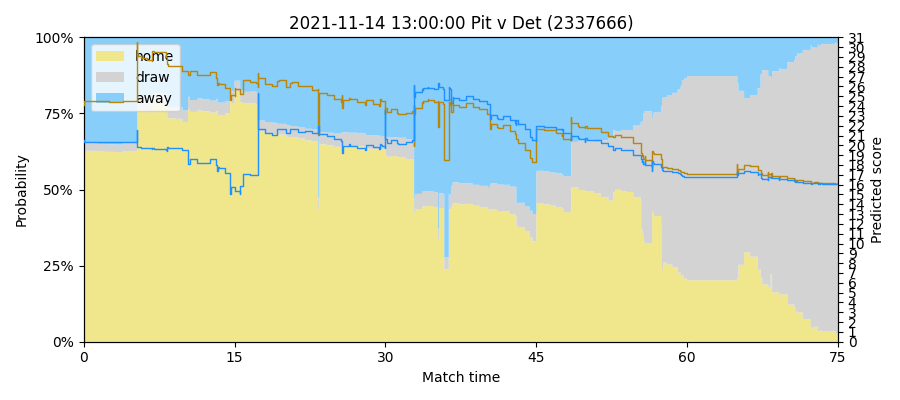

/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_32854/3618136909.py:75: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-k" (-> color='k'). The keyword argument will take precedence.
  h_ax_twin.plot(plot_x, plot_home_score, '-k', linewidth=1, zorder=10, color='darkgoldenrod', label='home score')
/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_32854/3618136909.py:80: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-k" (-> color='k'). The keyword argument will take precedence.
  h_ax_twin.plot(plot_x, plot_away_score, '-k', linewidth=1, zorder=10, color='dodgerblue', label='away score')


[0, 900, 1800, 2700, 3600, 4500]
['0', '15', '30', '45', '60', '75']


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_32854/3618136909.py:75: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-k" (-> color='k'). The keyword argument will take precedence.
  h_ax_twin.plot(plot_x, plot_home_score, '-k', linewidth=1, zorder=10, color='darkgoldenrod', label='home score')
/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_32854/3618136909.py:80: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-k" (-> color='k'). The keyword argument will take precedence.
  h_ax_twin.plot(plot_x, plot_away_score, '-k', linewidth=1, zorder=10, color='dodgerblue', label='away score')


[0, 900, 1800, 2700, 3600, 4500]
['0', '15', '30', '45', '60', '75']


In [37]:
# game_info_df = pd.read_csv(os.path.join(data_dir, 'opta_game_list.csv'), usecols=['game_code', 'game_date', 'home_team_name', 'away_team_name'])
game_info_df = game_df[['game_code', 'game_date', 'home_team_id', 'away_team_id', 'season', 'home_team_abbrev', 'away_team_abbrev']]
game_info_df['game_description'] = ['{0} {1} v {2} ({3})'.format(i.game_date, i.home_team_abbrev, i.away_team_abbrev, i.game_code) for _, i in game_info_df.iterrows()]
game_info_df = game_info_df.loc[game_info_df.game_code.isin(test_game_codes), ['game_code', 'game_description']]
game_info_df['ft_score'] = str(game_df.set_index('game_code').loc[game_info_df.game_code.values, 'away_score'].values) + "-" + str(game_df.set_index('game_code').loc[game_info_df.game_code.values, 'home_score'].values)

h_f = None
h_ax = None
h_ax_twin = None

def update_dashboard(change):
    global info_textbox
    info_textbox.value = ''
    if h_ax is not None:
        h_ax.cla()
        h_ax_twin.cla()
    plot()
    
def print_to_textbox(string, textbox_handle, clear_textbox=False):
    if textbox_handle is None:
        print(string)
    else:
        if clear_textbox or (textbox_handle.value == ''):
            textbox_handle.value = string
        else:
            textbox_handle.value += '<br>' + string

def plot():
    global h_f, h_ax, h_ax_twin
    if h_f is None:
        h_f, h_ax = plt.subplots(1, figsize=(9, 4))
        
    plot_game_code = game_info_df.set_index('game_description').loc[match_picker.value, 'game_code']
    plot_time = full_df.loc[full_df.game_code == plot_game_code, ['quarter', 'play_start_time']]
    plot_time = ((900 - plot_time.play_start_time) + \
                 (plot_time.quarter - 1 ) * 900).values
                 
    plot_input = full_df.loc[full_df.game_code == plot_game_code, input_names].values
    plot_running_score = full_df.loc[full_df.game_code == plot_game_code, ['home_start_score', 'away_start_score']].values
    plot_output = get_model_outputs(clf, plot_input, plot_running_score)    
    print_to_textbox('{0:d} prediction samples found'.format(plot_input.shape[0]), info_textbox)
    
    # Main axis (1X2 prediction)
    plot_x = np.append(np.vstack((plot_time[:-1], plot_time[1:])).flatten(order='F'), plot_time[-1])
    plot_y1 = np.vstack((plot_output['ft_outcome'][:, 0], plot_output['ft_outcome'][:, 0])).flatten(order='F')[:-1]
    plot_y2 = np.vstack((plot_output['ft_outcome'][:, 1], plot_output['ft_outcome'][:, 1])).flatten(order='F')[:-1]
    plot_y3 = np.vstack((plot_output['ft_outcome'][:, 2], plot_output['ft_outcome'][:, 2])).flatten(order='F')[:-1]
    h_ax.stackplot(plot_x, plot_y1, plot_y2, plot_y3,
                   labels=['home','draw','away'],
                   colors=['khaki', 'lightgray', 'lightskyblue'],
                   zorder=0)
    h_ax.legend(loc='upper left')

    x_tick_pos = (60 * np.arange(0, 31, 15)).tolist() + (60 * (np.arange(30, 61, 15) + 15)).tolist()
    x_tick_str = np.arange(0, 31, 15).astype(str).tolist() + (np.arange(30, 61, 15)+ 15 ).astype(str).tolist()
    print(x_tick_pos)
    print(x_tick_str)
    h_ax.set_xticks(x_tick_pos)
    h_ax.set_xticklabels(x_tick_str)
    h_ax.set_xlabel('Match time')
    h_ax.set_xlim(0, plot_x.max())
    h_ax.set_ylim(0, 1)
    h_ax.set_yticks(np.arange(0, 1.01, 0.25))
    h_ax.set_yticklabels(['{0:.0f}%'.format(100 * i) for i in np.arange(0, 1.01, 0.25)])    
    h_ax.set_ylabel('Probability')
    h_ax.set_title('{0}'.format(*game_info_df.set_index('game_code').loc[plot_game_code, ['game_description']].tolist()))
    
    # Twin axis (score prediction)
    if h_ax_twin is None:
        h_ax_twin = h_ax.twinx()
    # Home
    plot_home_score = plot_running_score[:, 0] + \
        np.sum(plot_output['home_score'] * np.tile(np.arange(max_home_score + 1), (plot_input.shape[0], 1)), axis=1)
    plot_home_score = np.vstack((plot_home_score, plot_home_score)).flatten(order='F')[:-1]
    h_ax_twin.plot(plot_x, plot_home_score, '-k', linewidth=1, zorder=10, color='darkgoldenrod', label='home score')
    # Away
    plot_away_score = plot_running_score[:, 1] + \
        np.sum(plot_output['away_score'] * np.tile(np.arange(max_away_score + 1), (plot_input.shape[0], 1)), axis=1)
    plot_away_score = np.vstack((plot_away_score, plot_away_score)).flatten(order='F')[:-1]
    h_ax_twin.plot(plot_x, plot_away_score, '-k', linewidth=1, zorder=10, color='dodgerblue', label='away score')
    
    max_score = int(np.ceil(np.append(plot_home_score, plot_away_score).max()))
    h_ax_twin.set_ylim(0, max_score)
    h_ax_twin.set_yticks(np.arange(0, max_score + 0.5))
    h_ax_twin.set_ylabel('Predicted score')
    
    h_f.tight_layout()
    
match_picker = widgets.Dropdown(
    options=game_info_df.game_description.values,
    description='Match'
)
run_btn = widgets.Button(
    description='Plot'
)
info_textbox = widgets.HTML(value="")

display(widgets.VBox([
    widgets.HBox([match_picker, run_btn]),
    info_textbox
]))
run_btn.on_click(update_dashboard)

In [17]:
x_tick_pos = (60 * np.arange(0, 61, 15)).tolist() + (60 * (np.arange(70, 71, 10))+15).tolist()
x_tick_str = np.arange(0, 61, 15).astype(str).tolist() + (np.arange(70, 71, 10)).astype(str).tolist()


In [15]:
plot_input = full_df.loc[full_df.game_code == 2337666, input_names].values
plot_running_score = full_df.loc[full_df.game_code == 2337666, ['home_start_score', 'away_start_score']].values

example = get_model_outputs(clf, plot_input, plot_running_score)

/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


In [21]:
example

{'remaining_score': array([[2.24979750e-08, 1.73204323e-25, 4.93717272e-08, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.08271942e-08, 1.44699770e-27, 2.19028050e-08, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [9.79380729e-09, 7.53773613e-28, 1.95939867e-08, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [9.55795065e-01, 1.15304129e-12, 1.31846893e-04, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [9.53032728e-01, 1.17257361e-12, 1.41641687e-04, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [9.52303179e-01, 6.42912232e-13, 1.34185175e-04, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]),
 'home_score': array([[6.08358439e-03, 8.35924714e-07, 1.80287778e-04, ...,
         5.21414198e-11, 0.00000000e+00, 2.34821834e-04],
        [5.11600713e-03, 3.85413807e-07, 1.48683830e-04, ...,
         5.45186292e-11, 0.00000000e+00, 2.2417488

In [20]:
pd.DataFrame(example["home_score"])

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
0,0.006084,8.359247e-07,0.000180,0.011511,9.833902e-07,0.000245,0.012364,0.016450,0.002133,0.009416,...,3.790586e-04,3.360499e-04,1.411208e-03,4.660161e-04,7.708880e-05,2.016634e-04,4.339811e-04,5.214142e-11,0.0,2.348218e-04
1,0.005116,3.854138e-07,0.000149,0.009935,3.925314e-07,0.000190,0.011133,0.014020,0.001782,0.008395,...,3.351053e-04,2.947612e-04,1.344000e-03,4.327265e-04,6.449100e-05,1.906563e-04,3.923342e-04,5.451863e-11,0.0,2.241749e-04
2,0.004996,3.468965e-07,0.000145,0.009735,3.462975e-07,0.000183,0.010971,0.013715,0.001739,0.008261,...,3.293168e-04,2.893368e-04,1.334247e-03,4.281406e-04,6.289700e-05,1.890641e-04,3.867787e-04,5.480964e-11,0.0,2.225975e-04
3,0.004991,3.453021e-07,0.000145,0.009727,3.444034e-07,0.000183,0.010964,0.013702,0.001737,0.008255,...,3.290646e-04,2.891006e-04,1.333818e-03,4.279397e-04,6.282792e-05,1.889939e-04,3.865364e-04,5.482219e-11,0.0,2.225278e-04
4,0.005080,3.735376e-07,0.000148,0.009875,3.781810e-07,0.000188,0.011085,0.013929,0.001769,0.008355,...,3.333794e-04,2.931435e-04,1.341115e-03,4.313642e-04,6.401417e-05,1.901851e-04,3.906796e-04,5.460597e-11,0.0,2.237089e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,0.975621,3.779180e-09,0.000233,0.016305,2.169550e-09,0.000003,0.001825,0.005366,0.000500,0.000011,...,1.664706e-21,1.515850e-36,4.536993e-23,4.999321e-22,1.272909e-15,3.819896e-40,9.414974e-22,3.927692e-17,0.0,2.161666e-14
263,0.976149,2.603321e-09,0.000209,0.016605,1.515690e-09,0.000003,0.001681,0.004800,0.000427,0.000009,...,7.486102e-22,3.891238e-37,1.796997e-23,2.241977e-22,7.515053e-16,8.499504e-41,4.268017e-22,2.816264e-17,0.0,1.338790e-14
264,0.973927,3.003182e-09,0.000230,0.017897,1.823001e-09,0.000004,0.001897,0.005406,0.000485,0.000011,...,1.353442e-21,1.127483e-36,3.618823e-23,4.054332e-22,1.122644e-15,2.720762e-40,7.658952e-22,3.939450e-17,0.0,1.921082e-14
265,0.972328,3.308847e-09,0.000246,0.018812,2.062341e-09,0.000004,0.002055,0.005852,0.000528,0.000013,...,2.008185e-21,2.291161e-36,5.769665e-23,6.016558e-22,1.466874e-15,5.908244e-40,1.130754e-21,4.926219e-17,0.0,2.443460e-14


In [15]:
os.system('say "done notebook"')


0